<a href="https://colab.research.google.com/github/skonwer/bw2color/blob/main/base_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# =============== Place365_dataset =====================
import os
from torchvision.datasets import Places365
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

# Paths
output_dir = "places365"
os.makedirs(f"{output_dir}/train", exist_ok=True)
os.makedirs(f"{output_dir}/val", exist_ok=True)

# Transform: Resize to 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset (small=True means 256x256 JPGs)
train = Places365(root=output_dir, split='train-standard', small=True, download=True, transform=transform)
val = Places365(root=output_dir, split='val', small=True, download=True, transform=transform)

train_loader = DataLoader(train, batch_size=1, shuffle=False)
val_loader = DataLoader(val, batch_size=1, shuffle=False)

#def dump(loader, split, max_samples=1000):
#    for i, (img, _) in enumerate(tqdm(loader, desc=split)):
#        if i >= max_samples:
#            break
#        save_image(img[0], f"{output_dir}/{split}/{i:06d}.jpg")

#dump(train_loader, "train", max_samples=1000)
#dump(val_loader, "val", max_samples=200)

100%|██████████| 67.5M/67.5M [00:05<00:00, 11.9MB/s]
100%|██████████| 26.1G/26.1G [26:44<00:00, 16.3MB/s]
100%|██████████| 525M/525M [00:32<00:00, 15.9MB/s]


In [2]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os
from PIL import Image
import numpy as np
import cv2
from skimage.color import rgb2lab, lab2rgb
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.utils.model_zoo as model_zoo
from collections import Counter

from torch.nn import MultiheadAttention
import lpips


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_loss = lpips.LPIPS(net='alex').to(device)  # or 'vgg'
print("Using device:", device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Using device: cuda


In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, img_dir, split='train', img_size=224, mode='classification', cluster_path='data/pts_in_hull.npy'):
        self.mode = mode
        self.img_size = img_size

        # Collect all image file paths. If using ImageFolder structure, traverse subdirectories.
        self.image_files = []
        for root, _, files in os.walk(img_dir):
            for fname in files:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_files.append(os.path.join(root, fname))
        self.image_files.sort()

        # Load ab cluster centers for quantization (for classification mode)
        if self.mode == 'classification':
            # pts_in_hull.npy should contain an array of shape (313, 2) for ab cluster centers
            self.ab_clusters = np.load(cluster_path)  # dtype float, shape (313,2)
            # Precompute a KD-tree or similar for speed (optional). Here we'll use a simple numpy method.

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            if hasattr(self, 'augment') or True:
                img = img.resize((self.img_size, self.img_size))
                if self.mode == 'train':
                    if np.random.rand() > 0.5:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
            img_np = np.array(img)
        img_np = img_np.astype(np.float32) / 255.0
        lab = rgb2lab(img_np)
        L = lab[:, :, 0]
        ab = lab[:, :, 1:]
        L_tensor = torch.from_numpy(L).unsqueeze(0).float()
        ab_tensor = torch.from_numpy(ab).permute(2,0,1).float()

        if self.mode == 'classification':
            H, W = L.shape
            small_H, small_W = H // 4, W // 4
            ab_small = cv2.resize(ab, (small_W, small_H), interpolation=cv2.INTER_AREA)
            ab_small = ab_small.astype(np.float32)
            ab_pixels = ab_small.reshape(-1, 2)
            dists = np.linalg.norm(ab_pixels[:, None, :] - self.ab_clusters[None, :, :], axis=2)
            cluster_indices = dists.argmin(axis=1).astype(np.int64)
            class_map = cluster_indices.reshape(small_H, small_W)
            class_tensor = torch.from_numpy(class_map)
            return L_tensor, class_tensor
        else:
            return L_tensor, ab_tensor

In [5]:
def visualize_colorization_samples(model, data_loader, device, num_images=4, save_path=None):
    model.eval()
    model.to(device)

    #with torch.no_grad():
    #    sample_L, _ = next(iter(data_loader))  # Get a batch
    #    sample_L = sample_L.to(device)
    #    pred_ab = model(sample_L)

    with torch.no_grad():
        sample_L, _ = next(iter(data_loader))  # Get a batch
        sample_L = sample_L[:1]  # Limit to 1 sample to avoid OOM
        sample_L = sample_L.to(device)
        pred_ab = model(sample_L)

    sample_L = sample_L.cpu().numpy()
    pred_ab = pred_ab.cpu().numpy()

    plt.figure(figsize=(num_images * 3, 6))

    for i in range(min(num_images, sample_L.shape[0])):
        # L and ab channels
        L_chan = sample_L[i, 0, :, :]
        ab_chan = pred_ab[i].transpose(1, 2, 0)

        # Combine and convert to RGB
        lab = np.concatenate([L_chan[:, :, np.newaxis], ab_chan], axis=2)
        rgb = lab2rgb(lab)

        # Plot grayscale L
        plt.subplot(2, num_images, i + 1)
        plt.imshow(L_chan, cmap='gray')
        plt.axis('off')
        plt.title("Grayscale")

        # Plot colorized output
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(rgb)
        plt.axis('off')
        plt.title("Colorized")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()


def visualize_random_colorization_samples(model, data_loader, device, num_images=4, save_path=None):
    model.eval()
    model.to(device)

    # Get random indices from the dataset
    dataset = data_loader.dataset
    indices = random.sample(range(len(dataset)), num_images)
    samples = [dataset[i] for i in indices]

    sample_L = torch.stack([s[0] for s in samples]).to(device)

    with torch.no_grad():
        pred_ab = model(sample_L)

    sample_L = sample_L.cpu().numpy()
    pred_ab = pred_ab.cpu().numpy()

    plt.figure(figsize=(num_images * 3, 6))

    for i in range(num_images):
        L_chan = sample_L[i, 0, :, :]
        ab_chan = pred_ab[i].transpose(1, 2, 0)

        lab = np.concatenate([L_chan[:, :, np.newaxis], ab_chan], axis=2)
        rgb = lab2rgb(lab)

        plt.subplot(2, num_images, i + 1)
        plt.imshow(L_chan, cmap='gray')
        plt.axis('off')
        plt.title("Grayscale")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(rgb)
        plt.axis('off')
        plt.title("Colorized")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()


def compute_class_weights_fast(dataset, num_bins=313, smooth=1e-3, sample_size=10000):
    freq = np.zeros(num_bins)
    total_pixels = 0

    indices = random.sample(range(len(dataset)), min(sample_size, len(dataset)))
    for idx in indices:
        _, target = dataset[idx]
        hist = np.bincount(target.flatten(), minlength=num_bins)
        freq += hist
        total_pixels += hist.sum()

    freq = freq / total_pixels
    weights = 1 / (freq + smooth)
    weights = weights / np.sum(freq * weights)
    return torch.tensor(weights, dtype=torch.float32)

In [6]:
# Example:
train_dir = "places365/data_256_standard"
val_dir = "places365/val_256"

# Create dataset and dataloader
train_dataset = ColorizationDataset(train_dir, split='train', img_size=224, mode='classification', cluster_path='./data/pts_in_hull.npy')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ColorizationDataset(val_dir, split='val', img_size=224, mode='classification')
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
#weights = compute_class_weights_fast(train_dataset, sample_size=5000)
#torch.save(weights, './data/class_weights.pt')

In [7]:
class ECCVGenerator(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()
        self.l_cent = 50.0
        self.l_norm = 100.0
        self.ab_norm = 110.0

        # Encoder
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 2, 1), nn.ReLU(True),
            norm_layer(64)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU(True),
            norm_layer(128)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 2, 1), nn.ReLU(True),
            norm_layer(256)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer8 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 313, 1, 1, 0)
        )

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, 1, 1, 0, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

    def normalize_l(self, L):
        return (L - self.l_cent) / self.l_norm

    def unnormalize_ab(self, ab):
        return ab * self.ab_norm

    def forward(self, input_l):
        conv1 = self.layer1(self.normalize_l(input_l))
        conv2 = self.layer2(conv1)
        conv3 = self.layer3(conv2)
        conv4 = self.layer4(conv3)
        conv5 = self.layer5(conv4)
        conv6 = self.layer6(conv5)
        conv7 = self.layer7(conv6)
        conv8 = self.layer8(conv7)

        ab_prob = self.softmax(conv8)
        ab_pred = self.model_out(ab_prob)
        ab_pred_upsampled = self.upsample4(ab_pred)
        ab_pred_unnorm = self.unnormalize_ab(ab_pred_upsampled)
        return ab_pred_unnorm

In [15]:
def get_logits(model, L):
    m = model.module if isinstance(model, nn.DataParallel) else model
    x = m.layer1(m.normalize_l(L))
    x = m.layer2(x)
    x = m.layer3(x)
    x = m.layer4(x)
    x = m.layer5(x)
    x = m.layer6(x)
    x = m.layer7(x)
    return m.layer8(x)


def load_best_checkpoint(model, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model_state = checkpoint.get('model_state_dict', checkpoint)
        best_acc = checkpoint.get('best_val_accuracy', 0.0)
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(model_state)
        else:
            model.load_state_dict(model_state)
        print(f"Loaded checkpoint from: {checkpoint_path} with best accuracy: {best_acc:.2f}%")
        return True, best_acc
    else:
        print(f"No checkpoint found at: {checkpoint_path}")
        return False, 0.0


def evaluate(model, val_loader, criterion, use_classification, device, return_accuracy=False):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for L, target in val_loader:
            L, target = L.to(device), target.to(device)
            if use_classification:
                logits = get_logits(model, L)
                loss = criterion(logits, target)
                preds = logits.argmax(dim=1)
                total_correct += (preds == target).sum().item()
                total_pixels += target.numel()
            else:
                ab_pred = model(L)
                loss = criterion(ab_pred, target)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    if return_accuracy and use_classification:
        accuracy = 100.0 * total_correct / total_pixels
        return avg_loss, accuracy
    return avg_loss, None


def save_sample_images(model, val_loader, device, epoch):
    model.eval()
    sample_L, _ = next(iter(val_loader))
    sample_L = sample_L.to(device)
    with torch.no_grad():
        pred_ab = model(sample_L)

    for i in range(min(4, pred_ab.size(0))):
        L_chan = sample_L[i].cpu().numpy().transpose(1, 2, 0)
        ab_chan = pred_ab[i].cpu().numpy().transpose(1, 2, 0)
        lab_img = np.concatenate([L_chan, ab_chan], axis=2)
        rgb_img = (np.clip(255 * np.clip(lab2rgb(lab_img), 0, 1), 0, 255)).astype('uint8')
        Image.fromarray(rgb_img).save(f"sample_epoch{epoch}_img{i}.png")


def train(model, train_loader, val_loader, use_classification=True,
          use_class_weights=False,
          num_epochs=50, log_interval=10, save_interval=5,
          prefix="colorization_model", checkpoint_dir="checkpoints"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    os.makedirs(checkpoint_dir, exist_ok=True)
    best_path = os.path.join(checkpoint_dir, f"{prefix}_best.pth")

    try:
        resumed, best_val_accuracy = load_best_checkpoint(model, best_path)
    except:
        resumed, best_val_accuracy = False, 0.0
        print(f"No checkpoint found at: {best_path}")

    # Set up loss function
    if use_classification:
        if use_class_weights:
            try:
                class_weights = torch.load("./data/class_weights.pt").to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
            except FileNotFoundError:
                print("class_weights.pt not found — continuing without class weights.")
                criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total_pixels = 0

        for batch_idx, (L, target) in enumerate(train_loader):
            L, target = L.to(device), target.to(device)
            optimizer.zero_grad()

            if use_classification:
                logits = get_logits(model, L)
                loss = criterion(logits, target)
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total_pixels += target.numel()
            else:
                ab_pred = model(L)
                loss = criterion(ab_pred, target)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (batch_idx + 1) % log_interval == 0:
                avg_loss = running_loss / log_interval
                if use_classification:
                    train_acc = 100.0 * correct / total_pixels
                    print(f"[Epoch {epoch}] Batch {batch_idx + 1}/{len(train_loader)} | Loss: {avg_loss:.4f} | Accuracy: {train_acc:.2f}%")
                else:
                    print(f"[Epoch {epoch}] Batch {batch_idx + 1}/{len(train_loader)} | Loss: {avg_loss:.4f}")
                running_loss = 0.0

        # Validation after the epoch
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, use_classification, device, return_accuracy=True)
        print(f"[Epoch {epoch}] Validation Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.2f}%")

        # Save best model
        if use_classification and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save({
                'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
                'best_val_accuracy': best_val_accuracy
            }, best_path)
            print(f"New best model saved at end of epoch {epoch}")

        # Save regular checkpoint
        if epoch % save_interval == 0 or epoch == num_epochs:
            save_path = os.path.join(checkpoint_dir, f"{prefix}_epoch{epoch}.pth")
            torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), save_path)
            print(f"Checkpoint saved to {save_path}")
            save_sample_images(model, val_loader, device, epoch)

        scheduler.step()

def test_model(model, test_loader, use_classification=True,
               checkpoint_path="checkpoints/colorization_model_best.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found at: {checkpoint_path}")
        return

    resumed, _ = load_best_checkpoint(model, checkpoint_path)

    criterion = nn.CrossEntropyLoss() if use_classification else nn.MSELoss()
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for L, target in test_loader:
            L, target = L.to(device), target.to(device)

            if use_classification:
                logits = get_logits(model, L)
                loss = criterion(logits, target)

                preds = logits.argmax(dim=1)
                total_correct += (preds == target).sum().item()
                total_pixels += target.numel()
            else:
                ab_pred = model(L)
                loss = criterion(ab_pred, target)

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}")
    if use_classification:
        accuracy = 100.0 * total_correct / total_pixels
        print(f"Test Accuracy: {accuracy:.2f}%")



In [9]:
def save_initial_pretrained_checkpoint(prefix="colorization_model", checkpoint_dir = "checkpoints"):

    model = ECCVGenerator()
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_path = os.path.join(checkpoint_dir, f"{prefix}_best.pth")

    # Skip if already exists
    if os.path.exists(best_path):
        print(f"Checkpoint already exists at {best_path}. Skipping.")
        return

    print("Downloading and loading pretrained ECCV16 weights...")

    # Load pretrained weights
    state_dict = model_zoo.load_url(
        'https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',
        map_location='cpu',
        check_hash=True
    )

    # Rename keys
    renamed_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("model") and k[5].isdigit():
            layer_num = k[5]
            new_key = f"layer{layer_num}{k[6:]}"  # keep rest of the key unchanged
            renamed_state_dict[new_key] = v
        else:
            renamed_state_dict[k] = v


    missing, unexpected = model.load_state_dict(renamed_state_dict, strict=False)
    print("Missing keys:", missing)
    print("Unexpected keys:", unexpected)

    torch.save({
        "model_state_dict": model.state_dict(),
        "best_val_accuracy": 0.0
    }, best_path)

    print(f"Saved initial pretrained checkpoint to: {best_path}")


#save_initial_pretrained_checkpoint()
save_initial_pretrained_checkpoint(checkpoint_dir = "paper")

Checkpoint already exists at paper/colorization_model_best.pth. Skipping.


In [16]:
# training
model = ECCVGenerator()
train(model, train_loader, val_loader, use_classification=True, use_class_weights=False)

No checkpoint found at: checkpoints/colorization_model_best.pth
[Epoch 1] Batch 10/28180 | Loss: 5.1929 | Accuracy: 24.15%
[Epoch 1] Batch 20/28180 | Loss: 3.8322 | Accuracy: 26.14%
[Epoch 1] Batch 30/28180 | Loss: 3.3665 | Accuracy: 27.94%
[Epoch 1] Batch 40/28180 | Loss: 3.2088 | Accuracy: 28.74%
[Epoch 1] Batch 50/28180 | Loss: 3.0094 | Accuracy: 29.63%
[Epoch 1] Batch 60/28180 | Loss: 2.9160 | Accuracy: 30.12%
[Epoch 1] Batch 70/28180 | Loss: 2.9416 | Accuracy: 30.59%
[Epoch 1] Batch 80/28180 | Loss: 2.8477 | Accuracy: 30.86%
[Epoch 1] Batch 90/28180 | Loss: 2.9243 | Accuracy: 30.96%
[Epoch 1] Batch 100/28180 | Loss: 2.9031 | Accuracy: 31.13%
[Epoch 1] Batch 110/28180 | Loss: 2.8618 | Accuracy: 31.29%
[Epoch 1] Batch 120/28180 | Loss: 2.8597 | Accuracy: 31.40%
[Epoch 1] Batch 130/28180 | Loss: 2.8730 | Accuracy: 31.44%
[Epoch 1] Batch 140/28180 | Loss: 2.9068 | Accuracy: 31.48%
[Epoch 1] Batch 150/28180 | Loss: 2.8321 | Accuracy: 31.54%
[Epoch 1] Batch 160/28180 | Loss: 2.8291 | Ac

KeyboardInterrupt: 

In [19]:
# ========= Downloading Checkpoint ==============
from google.colab import files
import shutil

# Replace with your directory path
dir_path = '/content/checkpoints'
zip_path = '/content/checkpoints.zip'

# Zip the folder
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=dir_path)

# Download
files.download(zip_path)

KeyboardInterrupt: 

In [ ]:
# testing
model = ECCVGenerator()
test_model(model, val_loader, use_classification=True)

In [10]:
# Comparison between paper and our training
model_base_model = ECCVGenerator()
model_paper      = ECCVGenerator()

Loaded checkpoint from: paper/colorization_model_best.pth with best accuracy: 0.00%


<ipython-input-5-558a98313e63>:28: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab)


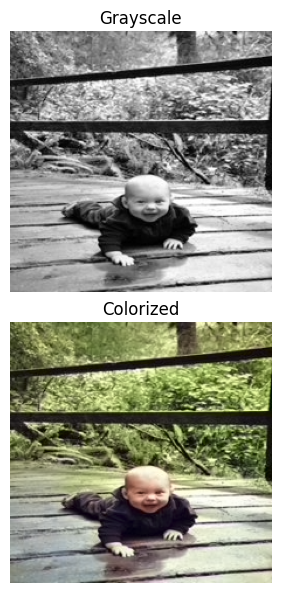

In [11]:
# Paper
load_best_checkpoint(model_paper, "paper/colorization_model_best.pth")
visualize_colorization_samples(model_paper, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Loaded checkpoint from: checkpoints/colorization_model_best.pth with best accuracy: 35.35%


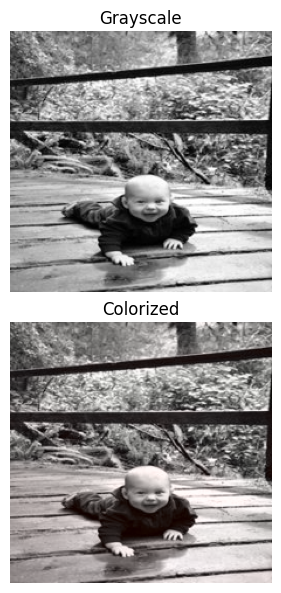

In [17]:
# Our model
load_best_checkpoint(model_base_model, "checkpoints/colorization_model_best.pth")
visualize_colorization_samples(model_base_model, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
# Our modification on classic ECC model
class AttentionECCVGenerator(nn.Module):
    def __init__(self, norm_layer=nn.BatchNorm2d, freeze_base=False):
        super(AttentionECCVGenerator, self).__init__()
        self.l_cent = 50.0
        self.l_norm = 100.0
        self.ab_norm = 110.0

        # ========== ENCODER ==========
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 2, 1), nn.ReLU(True),
            norm_layer(64)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, 2, 1), nn.ReLU(True),
            norm_layer(128)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 2, 1), nn.ReLU(True),
            norm_layer(256)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            norm_layer(512)
        )

        # ========== ATTENTION ==========
        self.attn_norm = LayerNorm(512)
        self.attn = MultiheadAttention(embed_dim=512, num_heads=4, batch_first=True)

        # ========== DECODER ==========
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 2, dilation=2), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            norm_layer(512)
        )
        self.layer8 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 313, 1, 1, 0)
        )

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, 1, 1, 0, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

        # Freeze base if requested
        if freeze_base:
            for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
                for param in layer.parameters():
                    param.requires_grad = False

    def apply_attention(self, x, attn, norm):
        B, C, H, W = x.shape
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, HW, C)
        x_flat = norm(x_flat)
        x_out, _ = attn(x_flat, x_flat, x_flat)
        x_out = x_out.permute(0, 2, 1).view(B, C, H, W)
        return x_out

    def normalize_l(self, L):
        return (L - self.l_cent) / self.l_norm

    def unnormalize_ab(self, ab):
        return ab * self.ab_norm

    def forward(self, input_l):
        conv1 = self.layer1(self.normalize_l(input_l))
        conv2 = self.layer2(conv1)
        conv3 = self.layer3(conv2)
        conv4 = self.layer4(conv3)

        # Apply a single attention layer
        conv4 = self.apply_attention(conv4, self.attn, self.attn_norm)

        conv5 = self.layer5(conv4)
        conv6 = self.layer6(conv5)
        conv7 = self.layer7(conv6)
        conv8 = self.layer8(conv7)

        ab_prob = self.softmax(conv8)
        ab_pred = self.model_out(ab_prob)
        ab_pred_upsampled = self.upsample4(ab_pred)
        ab_pred_unnorm = self.unnormalize_ab(ab_pred_upsampled)
        return ab_pred_unnorm

In [ ]:
def load_pretrained_weights(new_model, path_to_old_weights):
    old_state_dict = torch.load(path_to_old_weights, map_location='cpu')['model_state_dict']
    new_state_dict = new_model.state_dict()

    # Filter keys: only keep those present in both models and with matching shape
    filtered_state_dict = {
        k: v for k, v in old_state_dict.items()
        if k in new_state_dict and v.shape == new_state_dict[k].shape
    }

    print(f"Loaded {len(filtered_state_dict)}/{len(new_state_dict)} params from previous model.")
    new_model.load_state_dict(filtered_state_dict, strict=False)

In [ ]:
def load_pretrained_weights(new_model, path_to_old_weights):
    old_state_dict = torch.load(path_to_old_weights, map_location='cpu')['model_state_dict']
    new_state_dict = new_model.state_dict()

    # Replace 'model.' with 'layers.' in keys
    mapped_old_state_dict = {}
    for k, v in old_state_dict.items():
        new_k = k.replace("model.", "layers.")
        mapped_old_state_dict[new_k] = v

    # Filter keys: keep only those that match in both models and shape
    filtered_state_dict = {
        k: v for k, v in mapped_old_state_dict.items()
        if k in new_state_dict and v.shape == new_state_dict[k].shape
    }

    print(f"Loaded {len(filtered_state_dict)}/{len(new_state_dict)} parameters from checkpoint.")
    new_model.load_state_dict(filtered_state_dict, strict=False)

In [ ]:
model = AttentionECCVGenerator()  # your updated class name
load_pretrained_weights(model, "paper/colorization_model_best.pth")


In [ ]:
train(model, train_loader, val_loader, use_classification=True, checkpoint_dir = "checkpoints_attention")

In [ ]:
#model_attention = AttentionECCVGenerator()
#load_best_checkpoint(model_attention, "checkpoints_attention/colorization_model_best.pth")
visualize_colorization_samples(model, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
model_attention = AttentionECCVGenerator()
load_best_checkpoint(model_attention, "checkpoints_attention/colorization_model_best.pth")
visualize_colorization_samples(model_attention, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))